In [1]:
# Importing libraries

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn import svm

In [2]:
# Finding the files in the directorry

os.listdir("/kaggle/input/gene-expression")

['data_set_ALL_AML_independent.csv',
 'data_set_ALL_AML_train.csv',
 'actual.csv']

In [3]:
# Reading files

gene_labels = pd.read_csv("../input/gene-expression/actual.csv", index_col = 'patient')
gene_test = pd.read_csv("../input/gene-expression/data_set_ALL_AML_independent.csv")
gene_train = pd.read_csv("../input/gene-expression/data_set_ALL_AML_train.csv")

In [4]:
gene_labels.head()

,cancer
patient,
1,ALL
2,ALL
3,ALL
4,ALL
5,ALL


In [5]:
gene_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
gene_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [7]:
# Number of NAs

print(f"Number of empty cell for test dataset: {gene_test.isna().sum().sum()}")
print(f"Number of empty cell for train dataset: {gene_train.isna().sum().sum()}")
print(f"Number of empty cell for label dataset: {gene_labels.isna().sum().sum()}")

Number of empty cell for test dataset: 0
Number of empty cell for train dataset: 0
Number of empty cell for label dataset: 0


# Data Preparation

In [8]:
# Extraction of 'call' columns from the train and test datasets
#                for furthur processing

call_test = [col for col in gene_test.columns if 'call' in col]
gene_test_call = gene_test[call_test]
gene_test.drop(call_test, axis = 1, inplace = True)


call_train = [col for col in gene_train.columns if 'call' in col]
gene_train_call = gene_train[call_train]
gene_train.drop(call_train, axis = 1, inplace = True)

In [9]:
# transform the string categories into numbers

gene_train_call = gene_train_call.replace({"A": 0, "P": 1, "M": 2})
gene_test_call = gene_test_call.replace({"A": 0, "P": 1, "M": 2})

In [10]:
# add rownames which include the "Gene Accession number" + "Call"

rownames = "Call " + gene_train.iloc[:,1]
gene_train_call.index = rownames
gene_test_call.index = rownames

# extract ids for patients
ids_train = list(gene_train.columns[2:])
ids_test = list(gene_test.columns[2:])

gene_train_call.columns = ids_train
gene_test_call.columns = ids_test

gene_train_call = gene_train_call.T
gene_test_call = gene_test_call.T

In [11]:
train_ids = pd.to_numeric(gene_train_call.index)
test_ids = pd.to_numeric(gene_test_call.index)

train_labels = []
test_labels = []

for i in train_ids:
    train_labels.append(gene_labels.iloc[i - 1, 0])

for j in test_ids:
    test_labels.append(gene_labels.iloc[j - 1, 0])
    
train_labels = pd.concat([pd.DataFrame(train_ids), pd.DataFrame(train_labels)], 
                         axis = 1, ignore_index = False)
train_labels.columns = ["patient", "cancer"]

test_labels = pd.concat([pd.DataFrame(test_ids), pd.DataFrame(test_labels)], 
                        axis = 1, ignore_index = False)
test_labels.columns = ["patient", "cancer"]


y_train = train_labels.iloc[:,1]
y_test = test_labels.iloc[:,1]


y_train = y_train.replace({"ALL": 0, "AML": 1})
y_train = list(y_train)


y_test = y_test.replace({"ALL": 0, "AML": 1})
y_test = list(y_test)

In [12]:
gene_names = gene_train.iloc[:, 1]
gene_train = gene_train.iloc[:, 2:]
gene_train = gene_train.T
gene_train.columns = gene_names
gene_train.index = train_ids

gene_test = gene_test.iloc[:,2:]
gene_test = gene_test.T
gene_test.columns = gene_names
gene_test.index = test_ids
gene_test.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
47,-243,-218,-163,182,-289,-268,-285,-172,52,-134,...,174,277,6,81,2,722,170,0,510,-73
48,-130,-177,-28,266,-170,-326,-222,-93,10,159,...,233,643,51,450,-46,612,370,29,333,-19


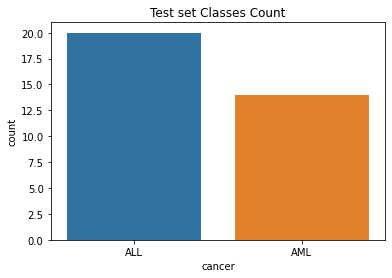

In [13]:
ax = sns.countplot(x="cancer", data=test_labels, order = ["ALL", "AML"]).set_title("Test set Classes Count")

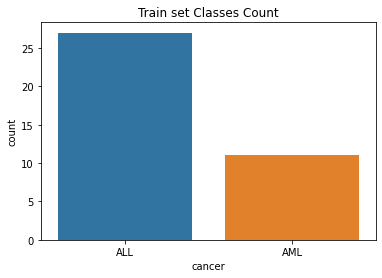

In [14]:
ax = sns.countplot(x = "cancer", data = train_labels, order = ["ALL", "AML"]).set_title("Train set Classes Count")

# Data Normalization

In [15]:
scaler = MinMaxScaler()
gene_train = scaler.fit_transform(gene_train)
gene_train = pd.DataFrame(gene_train, columns = gene_names, index = train_ids)

In [16]:
gene_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,0.531440,0.566775,0.435315,0.289720,0.502041,0.365354,0.755011,0.653759,0.915068,0.542526,...,0.475460,0.200840,0.133838,0.141710,0.457317,0.282075,0.269663,0.521212,0.060407,0.438462
2,0.683570,0.827362,0.534965,0.745327,0.565306,0.614173,0.165924,0.671982,0.501370,0.372423,...,0.426380,0.428971,0.358586,0.162987,0.579268,0.276887,0.237828,0.369697,0.024413,0.615385
3,0.811359,0.905537,0.000000,0.806075,0.336735,0.220472,0.570156,0.218679,0.789041,0.000000,...,0.874233,0.682295,0.532828,0.052991,1.000000,0.444811,0.689139,0.551515,0.071987,0.407692
4,0.691684,0.693811,1.000000,0.112150,0.248980,0.322835,0.709354,0.478360,0.358904,0.317010,...,0.644172,0.427572,1.000000,0.055399,0.012195,0.203774,0.120787,0.000000,0.040063,0.023077
5,0.750507,0.657980,0.403846,0.476636,0.634694,0.796850,0.537862,0.776765,0.416438,0.601804,...,0.386503,0.297411,0.593434,0.187876,0.524390,0.025943,0.255618,0.387879,0.018153,0.530769


In [17]:
n_components = 30
pca = PCA(n_components = n_components)
gene_train_pca = pca.fit_transform(gene_train)
gene_train_pca = pd.DataFrame(gene_train_pca)
gene_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,4.335955,1.873971,-4.492073,0.773770,-2.641525,4.426485,-1.742736,1.060366,-1.985917,2.537553,...,0.811086,-1.476379,0.281762,-0.586919,-3.808656,-1.267276,1.592440,-2.155034,1.507355,2.538646
1,-1.888290,2.243604,2.894183,1.310716,3.339522,-4.195679,0.379701,1.530271,0.615044,2.551174,...,-2.305903,1.370054,-3.205514,-0.413319,-3.610300,-2.110314,5.401324,2.236673,3.129337,-1.052334
2,12.031244,3.846473,-6.740047,9.491940,-0.144719,-1.574215,-5.980327,3.808565,1.018972,0.438956,...,0.629572,1.449634,1.107507,0.425798,0.150408,0.616999,-0.195955,0.292101,-0.390007,1.498904
3,3.429125,-1.189050,-5.278071,0.613200,0.322281,3.302466,7.713025,-0.653048,-2.128099,-4.104544,...,0.573854,5.971599,1.199560,-1.409250,5.358893,-3.884200,2.303694,0.739769,4.377079,-2.296540
4,-8.867465,7.034777,1.061889,0.976604,0.632451,2.662190,1.001255,-0.258231,-1.865961,-0.411062,...,1.557372,0.253278,1.274607,-0.047487,0.203232,1.291862,-0.745854,-0.750269,0.448097,3.040338


In [18]:
sum(sum(gene_train_pca.values))

-1.877664690397296e-14